In [6]:
from snowflake.snowpark import functions as F
from snowflake.snowpark.window import Window
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
import json
from snowflake.snowpark import Session

# Load connection parameters
with open('config.json') as f:
    connection_parameters = json.load(f)

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

try:
    session.sql("SELECT CURRENT_WAREHOUSE(), CURRENT_DATABASE(), CURRENT_SCHEMA()").show()
    print("Successfully connected to Snowflake!") 
except Exception as e:
    print(f"Error connecting to Snowflake: {str(e)}") 
    raise

---------------------------------------------------------------------
|"CURRENT_WAREHOUSE()"  |"CURRENT_DATABASE()"  |"CURRENT_SCHEMA()"  |
---------------------------------------------------------------------
|COMPUTE_WH             |GTFS_TEST             |NULL                |
---------------------------------------------------------------------

Successfully connected to Snowflake!


In [8]:
query = """
WITH stops AS
            (
            SELECT *
            FROM GTFS_TEST.SCHEDULE.STOPS
            WHERE LOAD_TIMESTAMP BETWEEN '2025-11-24 18:30:00.000' AND '2026-01-02 00:00:00.000'
            QUALIFY ROW_NUMBER() OVER(PARTITION BY STOP_ID, STOP_CODE, STOP_NAME, STOP_LAT, STOP_LON, MODE ORDER BY LOAD_TIMESTAMP) = 1
            ),
st_data AS (
    SELECT 
        TRIP_ID, 
        STOP_ID, 
        STOP_SEQUENCE, 
        ARRIVAL_TIME,
        DEPARTURE_TIME,
        SHAPE_DIST_TRAVELED, 
        MODE,
        FIRST_VALUE(DEPARTURE_TIME) OVER(PARTITION BY TRIP_ID, MODE ORDER BY STOP_SEQUENCE ASC) AS TRIP_START_TIME
    FROM GTFS_TEST.SCHEDULE.STOP_TIMES
    WHERE LOAD_TIMESTAMP BETWEEN '2025-12-18 00:00:00.000' AND '2026-01-02 00:00:00.000'
    QUALIFY ROW_NUMBER() OVER(PARTITION BY TRIP_ID, ARRIVAL_TIME, DEPARTURE_TIME, STOP_ID, SHAPE_DIST_TRAVELED, MODE ORDER BY LOAD_TIMESTAMP DESC) = 1
),
delays AS(
        SELECT
            d.TRIP_ID,
            d.STOP_ID,
            d.STOP_NAME,
            d.TRIP_HEADSIGN,
            d.STOP_SEQUENCE,
            d.ROUTE_SHORT_NAME,
            d.MODE,
            TO_DATE(d.EVENT_DATE, 'YYYYMMDD') AS EVENT_DATE,
            d.ACTUAL_ARRIVAL,
            d.PLANNED_ARRIVAL,
            d.DELAY,
            DATEDIFF(second, d.PLANNED_ARRIVAL, d.ACTUAL_ARRIVAL) AS DELAY_CALC,
            st.SHAPE_DIST_TRAVELED,
            s.STOP_CODE,
            s.STOP_DESC,
            s.STOP_LAT,
            s.STOP_LON,
            CAST(
                CASE 
                    WHEN CAST(SPLIT_PART(st.TRIP_START_TIME, ':', 1) AS INT) >= 24 
                    THEN 
                        LPAD(CAST(CAST(SPLIT_PART(st.TRIP_START_TIME, ':', 1) AS INT) - 24 AS STRING), 2, '0') 
                        || SUBSTRING(st.TRIP_START_TIME, 3, 6)
                    ELSE st.TRIP_START_TIME 
                END 
            AS TIME) AS TRIP_START_TIME_CLEANED
        FROM GTFS_TEST.SCHEDULE_DATA_MARTS.DELAYS_TABLE d
        LEFT JOIN st_data st
            ON  d.TRIP_ID = st.TRIP_ID
            AND d.STOP_SEQUENCE = st.STOP_SEQUENCE
            AND d.MODE = st.MODE
        LEFT JOIN stops s
            ON  d.STOP_ID = s.STOP_ID
            AND d.MODE = s.MODE
        WHERE d.LOAD_TIMESTAMP BETWEEN '2025-12-18 00:00:00.000' AND '2026-01-02 00:00:00.000'
        ORDER BY 8, 1, 5, 6, 9
        )
SELECT 
*,
CASE 
    WHEN ACTUAL_ARRIVAL::TIME < TRIP_START_TIME_CLEANED 
    THEN TIMEDIFF(second, TRIP_START_TIME_CLEANED, ACTUAL_ARRIVAL::TIME) + 86400
    ELSE TIMEDIFF(second, TRIP_START_TIME_CLEANED, ACTUAL_ARRIVAL::TIME)
END AS TIME_ELAPSED_SECONDS
FROM delays
"""


In [9]:
df_snow = session.sql(query)

df = df_snow.to_pandas()

In [10]:
query2 = '''
SELECT * FROM WEATHER_API_STAGING.DISTRICT_LOCATIONS
'''

df_snow2 = session.sql(query2)

df_district_locations = df_snow2.to_pandas()

# Feature Engineering 1 - Tworzenie dodatkowych cech bezwzględnych

In [11]:
# 1. utworzenie unikalnego klucza dla konkretnego dnia i konkretnego kursu
df['UNIQUE_TRIP_KEY'] = df['TRIP_ID'].astype(str) + "_" + df['TRIP_HEADSIGN'].astype(str) + "_" + df['EVENT_DATE'].astype(str) + "_" + df['MODE'].astype(str)

# 2. sortowanie danych chronologicznie i według sekwencji przystanków
df = df.sort_values(['UNIQUE_TRIP_KEY', 'STOP_SEQUENCE'])

# 3. obliczenie LAG wewnątrz unikalnego przejazdu
df['DELAY_LAG_1'] = df.groupby('UNIQUE_TRIP_KEY')['DELAY_CALC'].shift(1)

# 4. obliczenie różnicy między bieżącym opóźnieniem a poprzednim
df['DELAY_DELTA'] = df['DELAY_CALC'] - df['DELAY_LAG_1']

In [12]:
df_district_locations['DISTRICT_NAME'] = df_district_locations['DISTRICT_NAME'].str.replace(r"\s*\(.*\)", "", regex=True)
df_district_locations['DISTRICT_NAME'] = df_district_locations['DISTRICT_NAME'].str.replace(' ', '_')

In [13]:
import unicodedata

def remove_polish_characters(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

df_district_locations['DISTRICT_NAME'] = df_district_locations['DISTRICT_NAME'].apply(remove_polish_characters)


min_longitude_district = df_district_locations.loc[
    df_district_locations['LONGITUDE'] == df_district_locations['LONGITUDE'].min()
]

max_longitude_district = df_district_locations.loc[
    df_district_locations['LONGITUDE'] == df_district_locations['LONGITUDE'].max()
]

min_latitude_district = df_district_locations.loc[
    df_district_locations['LATITUDE'] == df_district_locations['LATITUDE'].min()
]

max_latitude_district = df_district_locations.loc[
    df_district_locations['LATITUDE'] == df_district_locations['LATITUDE'].max()
]

center_district = df_district_locations.loc[df_district_locations['DISTRICT_NUMBER'] == 1]

df_relevant_districts = pd.concat([min_longitude_district, max_longitude_district, min_latitude_district, max_latitude_district, center_district])


df_relevant_districts.index = df_relevant_districts['DISTRICT_NAME']

json_districts = df_relevant_districts.to_json(orient='records')

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # promień Ziemi w km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c


for item in json.loads(json_districts):
    col_name = f"dist_{item['DISTRICT_NAME']}"
    df[col_name] = df.apply(lambda row: haversine(row["STOP_LAT"], row["STOP_LON"], item["LATITUDE"],  item["LONGITUDE"]), axis=1)

In [15]:
df['WEEKDAY'] = df['ACTUAL_ARRIVAL'].dt.day_name()

df["seconds_since_midnight"] = (
    df['ACTUAL_ARRIVAL'].dt.hour * 3600 +
    df['ACTUAL_ARRIVAL'].dt.minute * 60 +
    df['ACTUAL_ARRIVAL'].dt.second
)

df['theta'] = 2 * np.pi * df["seconds_since_midnight"] / 86400

df['time_sin'] = np.sin(df["theta"])
df['time_cos'] = np.cos(df["theta"])

In [16]:
df = df[['UNIQUE_TRIP_KEY', 
         'TRIP_ID', 
         'TRIP_HEADSIGN', 
         'ROUTE_SHORT_NAME', 
         'MODE', 
         'STOP_ID', 
         'STOP_NAME', 
         'STOP_CODE',
         'STOP_DESC',
         'STOP_LAT',
         'STOP_LON',
         'STOP_SEQUENCE', 
         'ACTUAL_ARRIVAL', 
         'PLANNED_ARRIVAL', 
         'DELAY_CALC', 
         'DELAY_LAG_1',
         'DELAY_DELTA',
         'SHAPE_DIST_TRAVELED',
         'TRIP_START_TIME_CLEANED',
         'TIME_ELAPSED_SECONDS',
         'EVENT_DATE',
         'WEEKDAY',
         'seconds_since_midnight',
         'theta',
         'time_sin',
         'time_cos',
         'dist_Pradnik_Biały',
         'dist_Nowa_Huta',
         'dist_Swoszowice',
         'dist_Bienczyce',
         'dist_Stare_Miasto'
]]

In [17]:
df.head()

,UNIQUE_TRIP_KEY,TRIP_ID,TRIP_HEADSIGN,ROUTE_SHORT_NAME,MODE,STOP_ID,STOP_NAME,STOP_CODE,STOP_DESC,STOP_LAT,STOP_LON,STOP_SEQUENCE,ACTUAL_ARRIVAL,PLANNED_ARRIVAL,DELAY_CALC,DELAY_LAG_1,DELAY_DELTA,SHAPE_DIST_TRAVELED,TRIP_START_TIME_CLEANED,TIME_ELAPSED_SECONDS,EVENT_DATE,WEEKDAY,seconds_since_midnight,theta,time_sin,time_cos,dist_Pradnik_Biały,dist_Nowa_Huta,dist_Swoszowice,dist_Bienczyce,dist_Stare_Miasto
373308,1550_10174_Cichy Kącik_2025-12-19_M,1550_10174,Cichy Kącik,159,M,205,Os. Piastów,148-02,02,50.10089,20.01291,1,2025-12-19 04:37:00,2025-12-19 04:37:00,0,NaN,NaN,NaN,04:37:00,0,2025-12-19,Friday,16620,1.208641,0.935135,0.354291,9.327253,12.786750,15.222504,4.953488,6.961274
373309,1550_10174_Cichy Kącik_2025-12-19_M,1550_10174,Cichy Kącik,159,M,203,Piasta Kołodzieja,147-06,06,50.09808,20.01367,2,2025-12-19 04:37:57,2025-12-19 04:38:00,-3,0.0,-3.0,NaN,04:37:00,57,2025-12-19,Friday,16677,1.212786,0.936596,0.350412,9.328025,12.695324,14.950159,4.962533,6.811943
373310,1550_10174_Cichy Kącik_2025-12-19_M,1550_10174,Cichy Kącik,159,M,198,Popielidów,146-02,02,50.09945,20.01970,3,2025-12-19 04:39:15,2025-12-19 04:39:00,15,-3.0,18.0,NaN,04:37:00,135,2025-12-19,Friday,16755,1.218458,0.938568,0.345093,9.776637,12.285895,15.252173,4.509182,7.248952
373311,1550_10174_Cichy Kącik_2025-12-19_M,1550_10174,Cichy Kącik,159,M,195,Kruszwicka,145-01,01,50.09747,20.01921,4,2025-12-19 04:40:33,2025-12-19 04:40:00,33,15.0,18.0,NaN,04:37:00,213,2025-12-19,Friday,16833,1.224130,0.940511,0.339764,9.709155,12.295157,15.035563,4.596268,7.093892
373312,1550_10174_Cichy Kącik_2025-12-19_M,1550_10174,Cichy Kącik,159,M,194,Kleeberga,144-05,05,50.09619,20.01419,5,2025-12-19 04:41:30,2025-12-19 04:41:00,30,33.0,-3.0,NaN,04:37:00,270,2025-12-19,Friday,16890,1.228275,0.941911,0.335863,9.335234,12.637306,14.768221,4.979371,6.718578


In [18]:
num_features = df[[
                    'DELAY_CALC',
                    'DELAY_LAG_1',
                    'DELAY_DELTA',
                    'SHAPE_DIST_TRAVELED',
                    'TIME_ELAPSED_SECONDS',
                    'dist_Stare_Miasto', 
                    'dist_Pradnik_Biały', 
                    'dist_Swoszowice', 
                    'dist_Bienczyce', 
                    'dist_Nowa_Huta']]

num_features.describe().style.format("{:.2f}")

,DELAY_CALC,DELAY_LAG_1,DELAY_DELTA,SHAPE_DIST_TRAVELED,TIME_ELAPSED_SECONDS,dist_Stare_Miasto,dist_Pradnik_Biały,dist_Swoszowice,dist_Bienczyce,dist_Nowa_Huta
count,3581442.00,3485264.00,3485264.00,3183168.00,3581442.00,3581442.00,3581442.00,3581442.00,3581442.00,3581442.00
mean,201.92,193.39,11.59,7.07,16058.68,6.65,9.08,12.22,12.74,18.80
std,722.32,713.46,132.41,5.10,28568.81,87.88,87.86,87.67,87.96,87.90
min,-19171.00,-19171.00,-41502.00,0.00,0.00,0.25,0.32,0.32,0.19,0.66
25%,27.00,26.00,0.00,2.90,872.00,2.46,4.89,8.07,8.69,14.90
50%,74.00,72.00,0.00,6.42,2028.00,4.55,7.17,10.77,11.36,17.72
75%,172.00,169.00,7.00,10.45,9771.00,7.03,9.83,13.41,13.48,19.65
max,82359.00,43069.00,82312.00,34.97,86399.00,5879.95,5880.74,5871.06,5889.07,5890.15


### Wnioski 1
1. Błędy:
* Wartość maksymalna dla DELAY_CALC to aż 82 359 sekund (prawie 23 godziny!). Min DELAY_CALC = -19 171 s: To oznacza, że autobus przyjechał 5 godzin przed czasem. Wniosek: W danych występują błędy systemowe lub autobusy, które nigdy nie zakończyły trasy w systemie (ewentualnie z jakiegoś powodu doszło do tak ogromnego opóźnienia). Przed trenowaniem należy usunąć rekordy z nierealnymi opóźnieniami, ponieważ outliery zaburzają średnia. Inaczej model skupi się na tych błędach, ignorując normalny ruch.

* SEGMENT_SPEED_KMH: w statystykach tej kolumny występują błędy, mean = nan oraz max = inf. Jest to wynik dzielenia dystansku przez zerową wartość TIME_ELAPSED_SECONDS.

* Dystanse do dzielnic: Maksima wynoszą od 5880 do 5890 km. Wniosek: W zbiorze występują rekordy z błędnymi współrzędnymi, co powoduje, że odległość jest liczona w tysiącach kilometrów. Trzeba odfiltrować te punkty, bo zaburzą one wagę zmiennych przestrzennych.

* TIME_ELAPSED: 86 399 s = 23:59:59. Prawdopodobnie wiszący rekord w systemie.

2. Rozkład zmiennej DELAY_CALC

* Mediana to 74 s, a średnia to 201 s.

* Zmienna celu ma rozkład silnie prawoskośny. Większość autobusów jest w miarę punktualna, a tylko nieliczne są bardzo spóźnione. Jeżeli występuje opóźnienie, to wynosi ono nieco ponad minutę, ale outliery sztucznie zawyżają średnią prawie trzykrotnie.
* Odchylenie standardowe jest 3.5-razy większe niż średnia. To dowód na to, że dane są zanieczyszczone.

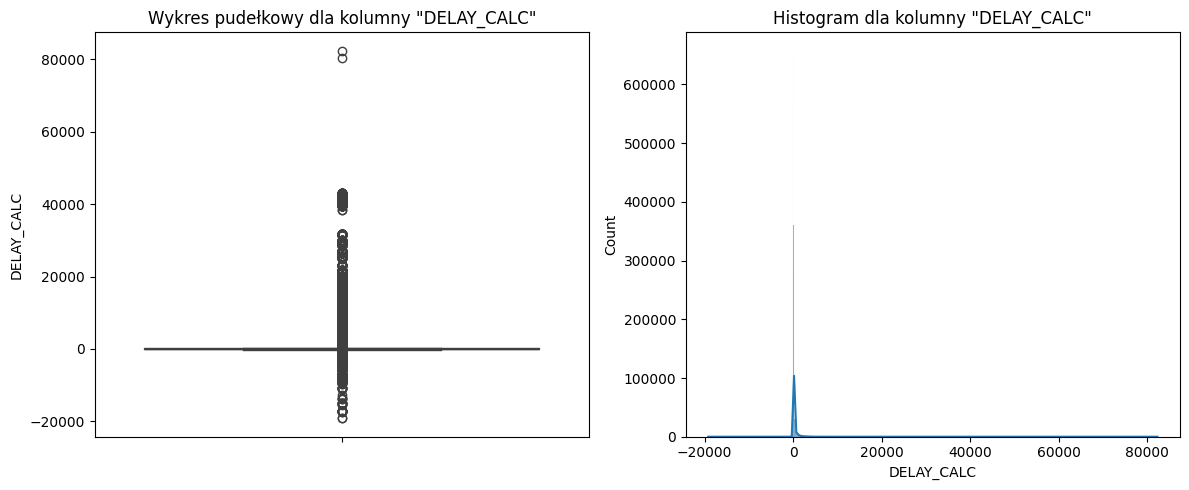

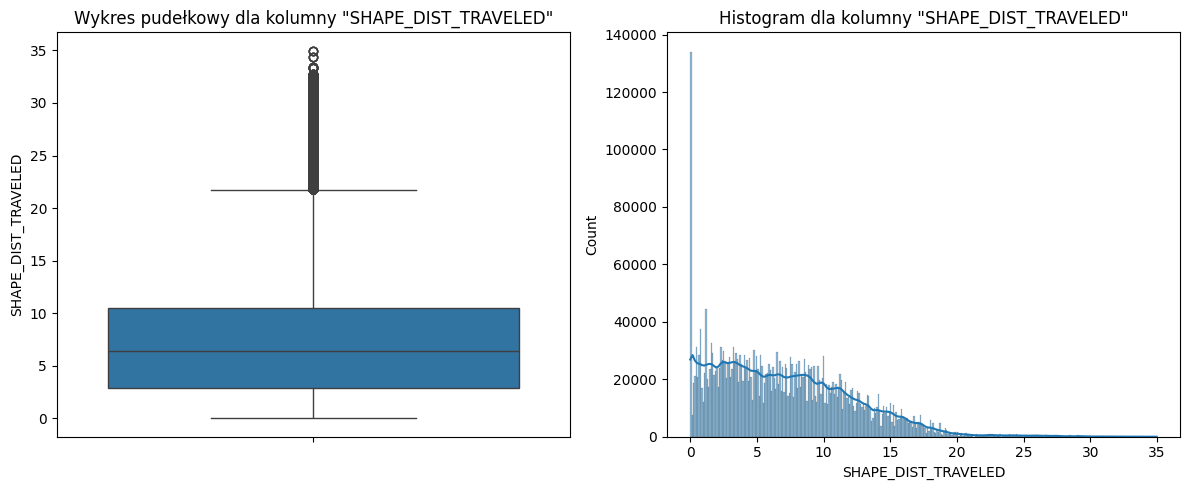

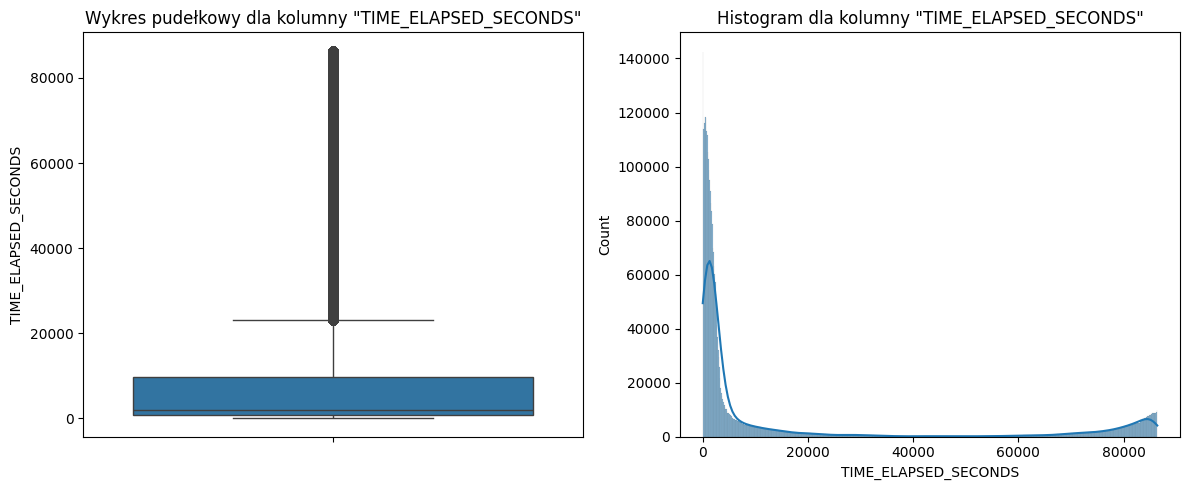

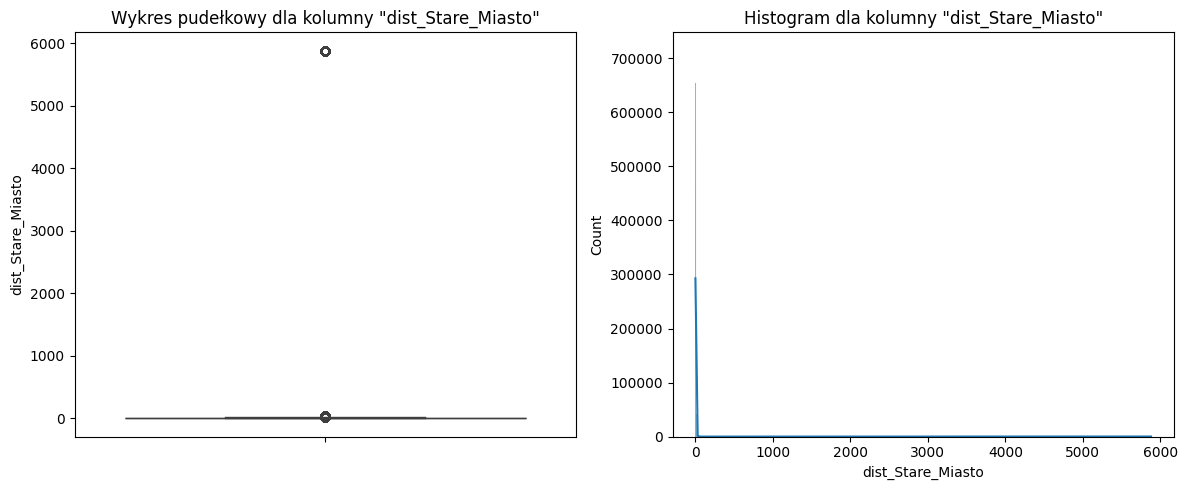

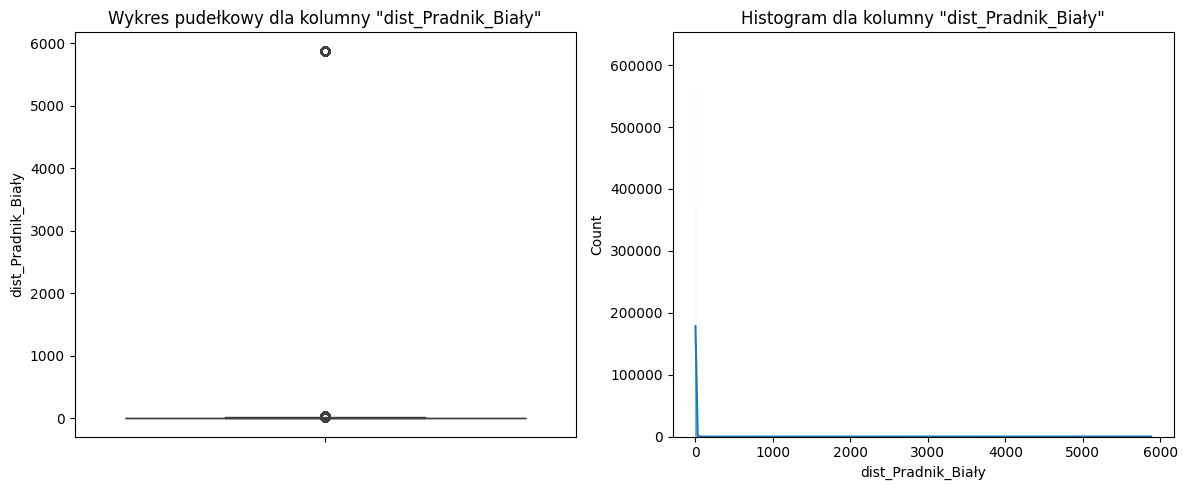

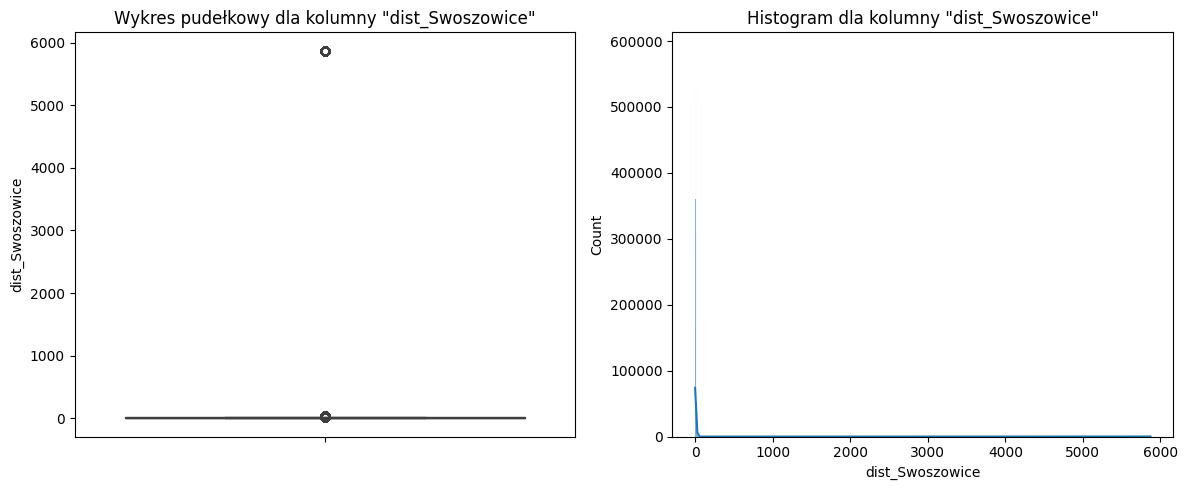

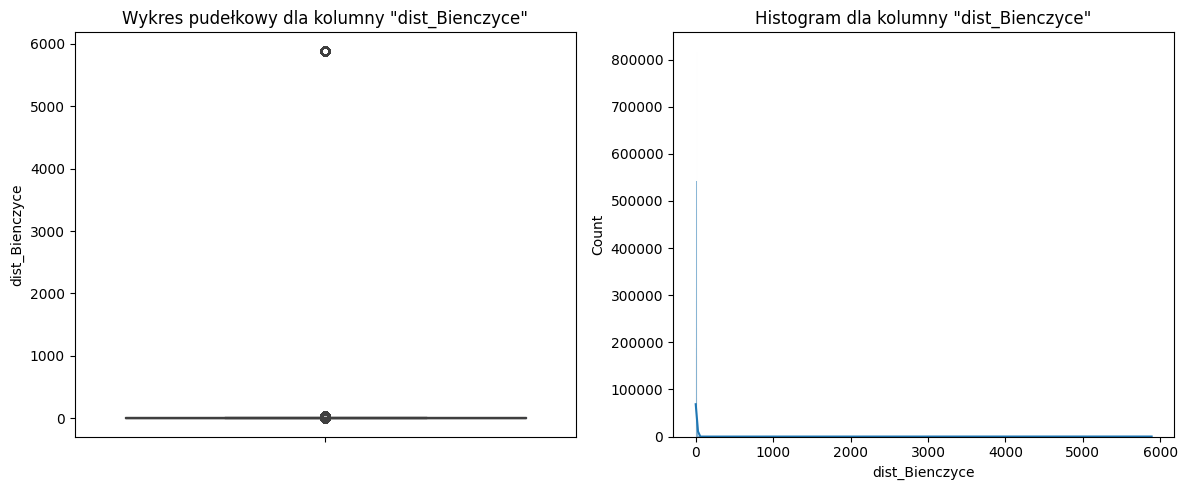

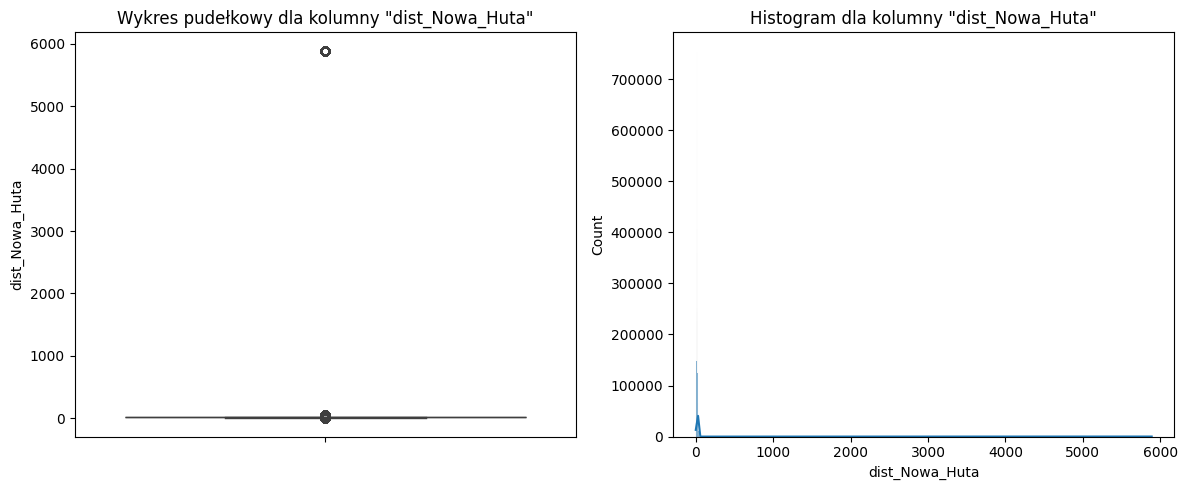

In [19]:
def plot_boxplots_and_histograms(df, features):
    for feature in features:
        plt.figure(figsize=(12, 5))

        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[feature])
        plt.title(f'Wykres pudełkowy dla kolumny "{feature}"')

        # Histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Histogram dla kolumny "{feature}"')

        plt.tight_layout()
        plt.show()

plot_boxplots_and_histograms(df, [
                    'DELAY_CALC',
                    'SHAPE_DIST_TRAVELED',
                    'TIME_ELAPSED_SECONDS',
                    'dist_Stare_Miasto', 
                    'dist_Pradnik_Biały', 
                    'dist_Swoszowice', 
                    'dist_Bienczyce', 
                    'dist_Nowa_Huta'])

### Wnioski 2
1. DELAY_CALC:
* Wykres pudełkowy pokazuje dużą liczbę outlierów, dodatnich i ujemnych.
* Środkowa część pudełka jest bardzo wąska co sugeruje, że większość dostępnych danych skupiona jest blisko mediany.
* Wartości odstające sięgają nawet 80 000 i poniżej -20 000, co może wskazywać na błędy pomiaru, nietypowe przypadki lub potrzebę transformacji danych.
* Histogram pokazuje skupienie wartości wokół zera, większość opóźnień jest niewielka lub zerowa.
* Długi ogon po stronie dodatniej sugeruje, że część przypadków ma bardzo duże opóźnienia.
* Rozkład jest silnie skośny.

2. SHAPE_DIST_TRAVELLED
* Rozstęp międzykwartylowy rozciąga od 2 do 10, co wskazuje na dużą koncentrację danych w tym zakresie.
* Rozkład jest asymetryczny prawostronnie, większość wartości skupia się blisko zera, a ogon rozciąga się w prawo. Taki rozkład wskazuje, że wiele tras jest bardzo krótkich, a tylko nieliczne są znacznie dłuższe.

3. TIME_ELAPSED_SECONDS
* Mediana znajduje się blisko dolnej granicy pudełka, co sugeruje, że większość wartości jest stosunkowo niska.
* Rozstęp międzykwartylowy (IQR) jest wąski, co oznacza, że połowa danych mieści się w niewielkim zakresie czasu.
* Występują liczne outliery i rozciągają się daleko poza górną granicę wykresu, co wskazuje na obecność bardzo długich czasów przejazdu lub przestojów.

4. Kolumny z dystansem
* Wyraźne outliery w okolicach 6000, wskazujące na błędy w danych.

# Data Cleaning

In [20]:
# usunięcię duplikatów
df = df.drop_duplicates()

In [21]:
# usunięcię wartości nierealnych i odstających
mask = (
    (df['TIME_ELAPSED_SECONDS'] < 7200) & 
    (df['DELAY_CALC'].between(-600, 3600)) & 
    (df['DELAY_LAG_1'].between(-600, 3600)) &
    (df['dist_Stare_Miasto'] < 50)
)

df_clean = df[mask].copy()

In [22]:
 # Obliczanie procenta brakujacych wartości dla poszczególnych kolumn.
def calculate_percentage(df, features):
    
    # Iteracja przez listę cech (kolumn), dla których chcemy obliczyć procent brakujących danych
    for feature in features:
        
        # Obliczenie procentu brakujących danych w danej kolumnie
        percentage_missing = (df[feature].isna().sum() / len(df)) * 100
        
        # Wyświetlenie wyniku w formacie z dwoma miejscami po przecinku
        print(f'Procent brakujacych danych w kolumnie {feature} wynosi {percentage_missing:.2f}%')

# Wywołanie funkcji calculate_percentage
calculate_percentage(df_clean, [
                    'SHAPE_DIST_TRAVELED',
                    'STOP_CODE',
                    'STOP_DESC'])

Procent brakujacych danych w kolumnie SHAPE_DIST_TRAVELED wynosi 15.24%
Procent brakujacych danych w kolumnie STOP_CODE wynosi 38.11%
Procent brakujacych danych w kolumnie STOP_DESC wynosi 38.11%


In [23]:
# usunięcie rekordów z brakującymi wartościami dla zmiennej 'SHAPE_DIST_TRAVELED'
df_clean = df_clean[~df_clean['SHAPE_DIST_TRAVELED'].isna()]

In [24]:
# usunięcie kolumn 'STOP_CODE' i 'STOP_DESC'
df_clean = df_clean.drop(['STOP_CODE', 'STOP_DESC'], axis=1)

In [25]:
# zapisanie oczyszczonego datasetu do dalszej analizy
df_clean.to_csv(f"delays_dataset_sample_final_cleaned.csv", index=False)